# Micro-facial Emotion Recognition

---


## 1- Introduction

Facial emotion recognition is a fundamental problem in computer vision and affective computing, with applications in human–computer interaction, healthcare, surveillance, and educational technology. Automatically identifying human emotions from facial images remains challenging due to variations in lighting, pose, occlusions, image quality, and the subtle visual differences between emotional expressions. These complexities make facial emotion recognition an active area of research and a suitable candidate for deep learning-based analysis.

The dataset for this project is sourced from the Kaggle competition “[Deep Learning (SSZG529) BITS Pilani](https://www.kaggle.com/competitions/deep-learning-sszg529-bits-pilani/overview/evaluation)”. The training set contains facial images categorized into five emotion classes:

* **Anger**
* **Happiness**
* **Surprise**
* **Contempt**
* **Other**

The objective of this project is to develop supervised deep learning models capable of classifying images into these five categories and to compare their performance based on prediction accuracy on the competition’s test dataset. By training and evaluating multiple architectures, the project aims to assess which model more effectively captures the discriminative facial features associated with different emotions.

Recent advancements in deep learning, particularly Convolutional Neural Networks have significantly improved automated emotion recognition, as CNNs excel at learning hierarchical spatial representations directly from pixel data. Leveraging these capabilities, this project explores CNN-based approaches to model complex facial patterns and evaluates their effectiveness for emotion classification.

Before building the models, **exploratory data analysis (EDA)** is conducted to examine the structure, distribution, and characteristics of the dataset. Understanding these properties is essential for designing an appropriate preprocessing pipeline and selecting suitable model architectures.



In [1]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from PIL import Image
import cv2
import random
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
mixed_precision.set_global_policy("mixed_float16")
print(keras.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6
2.10.0


In [2]:
# import data

train_path = 'train_data'
test_path = 'test_data'
test_csv = "test.csv"

# create a maping for different classes
id_class = {"Happiness": 1, "Other": 2, "Anger": 3, "Contempt": 4, "Surprise": 5}

label_list = []

# loop through all data and create a label list
for class_name, class_id in id_class.items():
    folder = os.path.join(train_path, class_name)
    for filename in os.listdir(folder):
        label_list.append({"filepath": os.path.join(folder, filename), "class_id": class_id, "class_name": class_name})

# turn into dataframe
train_labels = pd.DataFrame(label_list)
train_labels.head()

,filepath,class_id,class_name
0,train_data\Happiness\007_6_1_007_0498.jpg,1,Happiness
1,train_data\Happiness\007_6_1_007_0499.jpg,1,Happiness
2,train_data\Happiness\007_6_1_007_0500.jpg,1,Happiness
3,train_data\Happiness\007_6_1_007_0501.jpg,1,Happiness
4,train_data\Happiness\007_6_1_007_0502.jpg,1,Happiness


## 2- Exploratory Data Analysis (EDA)

### 2.1 Inspecting the data

The dataset is organized into class specific folders, and labels are inferred directly from folder names. Each data sample consists of:

* **Image File (Input Feature)**

  * Pixel intensity values from facial images.
  * All images are grayscale with color mode **'L'**.
  * Image dimensions are consistent across the dataset: **(650 × 960 × 3)**.

* **Target Label (Output Feature)**

  * Encoded as:

    * Happiness → 1
    * Other → 2
    * Anger → 3
    * Contempt → 4
    * Surprise → 5

Since this is an image-based deep learning problem, the raw pixel values act as features, and no handcrafted numerical features are explicitly provided. The dataset contains the following number of samples per class:

| Emotion   | Image Count |
| --------- | ----------- |
| Anger     | 3362        |
| Other     | 1702        |
| Happiness | 1550        |
| Surprise  | 850         |
| Contempt  | 717         |

**Observation 1**

* No missing image files were detected.
* No inconsistent color formats were present.
* No corrupted image files were encountered during loading.

**Takeaway:** This indicates that the dataset is clean and well-structured, requiring minimal preprocessing.



In [3]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    8181 non-null   object
 1   class_id    8181 non-null   int64 
 2   class_name  8181 non-null   object
dtypes: int64(1), object(2)
memory usage: 191.9+ KB


In [4]:
# check all dataset for image color profile and dimension
color_p = {}
dims = {}

for root, dirs, files in os.walk(train_path):
    for f in files:
        if f.lower().endswith(".jpg"):
            img_c = Image.open(os.path.join(root, f))
            img_d = cv2.imread(os.path.join(root, f))
            color = img_c.mode
            dim = img_d.shape
            color_p[color] = color_p.get(color, 0) + 1
            dims[dim] = dims.get(dim, 0) + 1

print("Color Profile and counts:")
print(color_p)
print("dimension and counts:")
print(dims)

Color Profile and counts:
{'L': 8181}
dimension and counts:
{(650, 960, 3): 8181}


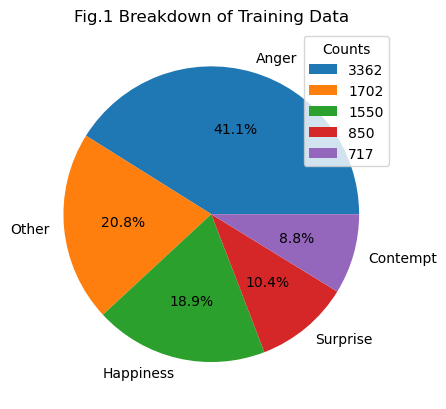

In [5]:
# create a size count for the plot
sizes = train_labels['class_name'].value_counts()

# visualize the make-up of the training data
fig, ax = plt.subplots()
wedges, _, _, = ax.pie(sizes, labels= sizes.index, autopct = '%1.1f%%')
ax.set_title('Fig.1 Breakdown of Training Data')
# add counts as legend
ax.legend(wedges, [f"{count}" for count in sizes.values], title="Counts")

**Observation 2**

* The dataset is **significantly imbalanced**.
* The **Anger** class dominates the dataset.
* The **Contempt** and **Surprise** classes are under-represented.

This imbalance can bias the model toward predicting majority classes and lead to poor minority-class performance. Class imbalance may result in high overall accuracy but poor recall for minority classes.

**Potential Remedies**:

  * Class weighting
  * Data augmentation

class-wise average pixel intensity histograms were computed across all training images. For each image, a 256-bin histogram over grayscale intensity values (0–255) was calculated, accumulated per class, and normalized to produce the average intensity distribution shown in Figure 3.

The resulting distributions indicate that all emotion classes exhibit multi-modal intensity patterns, reflecting the presence of dark background regions, mid-tone facial areas, and bright highlight regions within the images. A prominent spike near the highest intensity values (close to 255) is observed for several classes, particularly **Anger** and **Surprise**, suggesting the presence of overexposed regions or strong lighting effects in some images.

Although minor class-wise variations exist,such as slightly higher mid range intensities for **Happiness** and stronger high intensity peaks for **Anger**. The overall distributions across all five classes show substantial overlap.


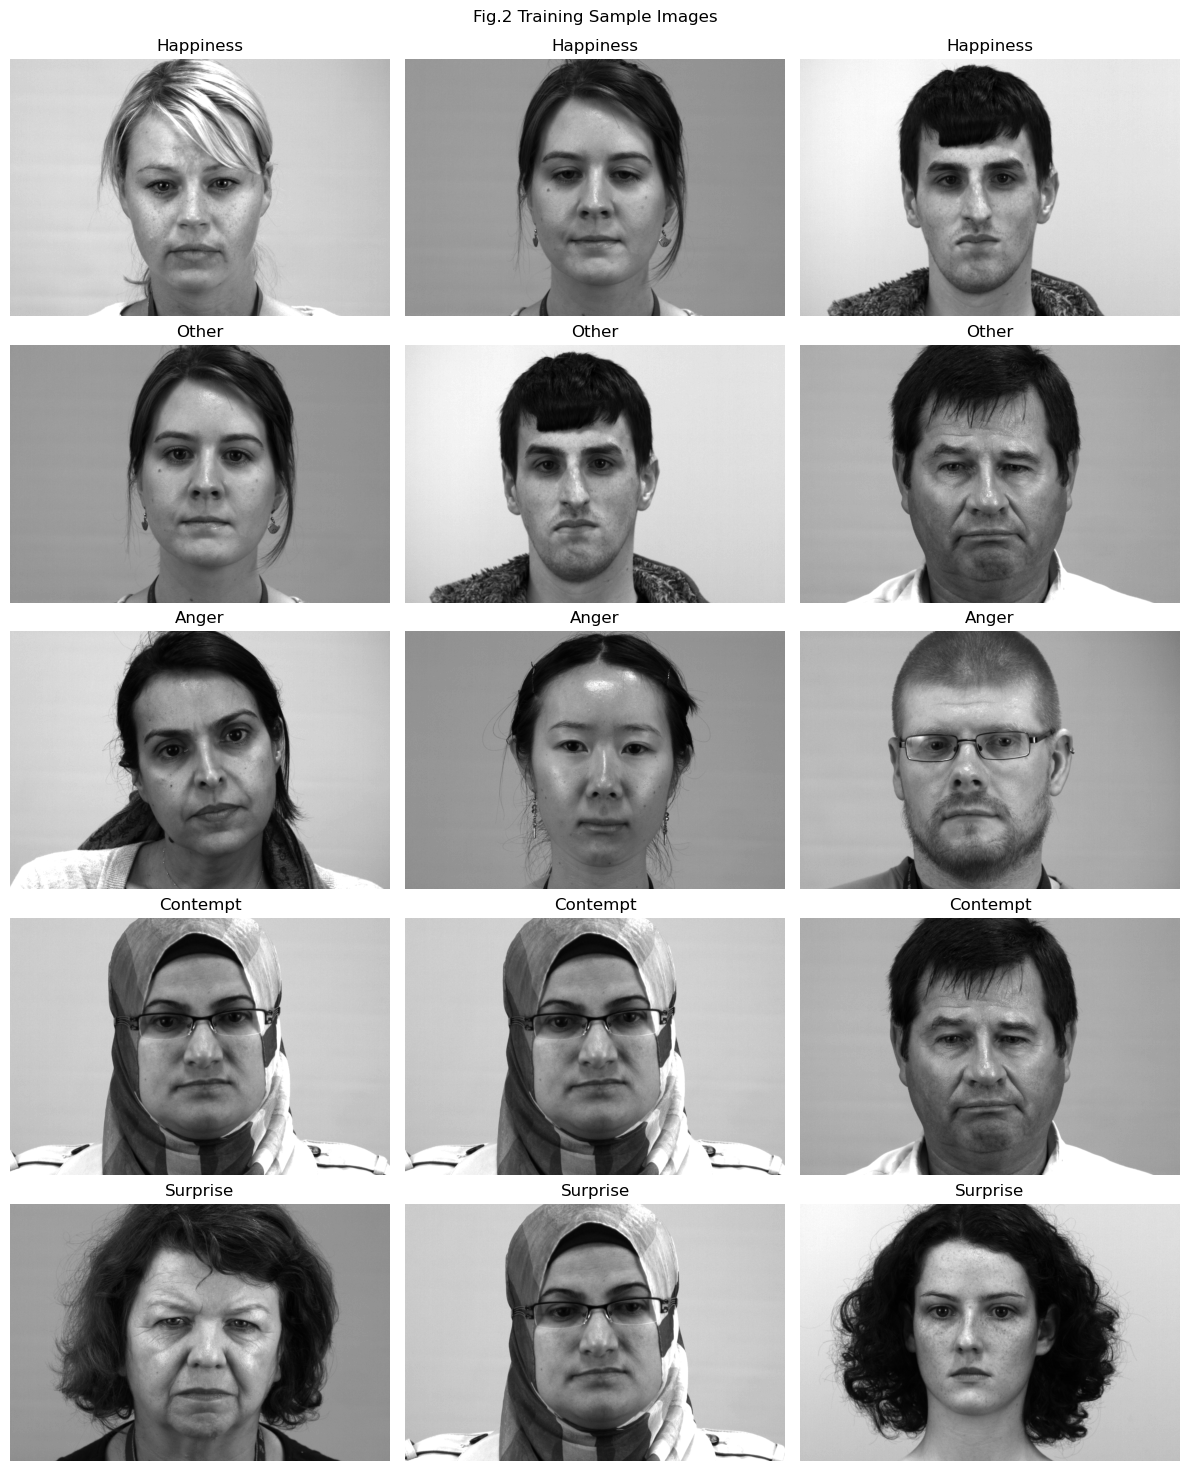

In [6]:
# visualize sample images
classes = train_labels["class_name"].unique()

plt_idx = 1
plt.figure(figsize=(12, 15))


for class_name in classes:
    class_subset = train_labels[train_labels["class_name"] == class_name]
    # randomly select 3 images per class
    sampled_rows = class_subset.sample(3, random_state=30)
    # iterate thru images and plot each
    for _, row in sampled_rows.iterrows():
        img_path = row["filepath"]
        img = Image.open(img_path)
        
        plt.subplot(5, 3, plt_idx)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
        
        plt_idx += 1
        
plt.suptitle('Fig.2 Training Sample Images\n')
plt.tight_layout()
plt.show()

In [7]:
# initialize containers for histograms and counts
histograms = {clss: np.zeros(256, dtype=np.float64) for clss in classes}
counts = {clss: 0 for clss in classes}

# loop over all images and accumulate histograms per class
for _, row in train_labels.iterrows():
    clss = row["class_name"]
    img_path = row["filepath"]
    
    img = Image.open(img_path)
    arr = np.array(img).flatten()
    
    # compute histogram with 256 bins
    hist, _ = np.histogram(arr, bins=256, range=(0, 255))
    
    histograms[clss] += hist
    counts[clss] += 1

# convert summed histograms to average and normalize to a probability distribution
for clss in classes:
    if counts[clss] > 0:
        histograms[clss] = histograms[clss] / histograms[clss].sum()


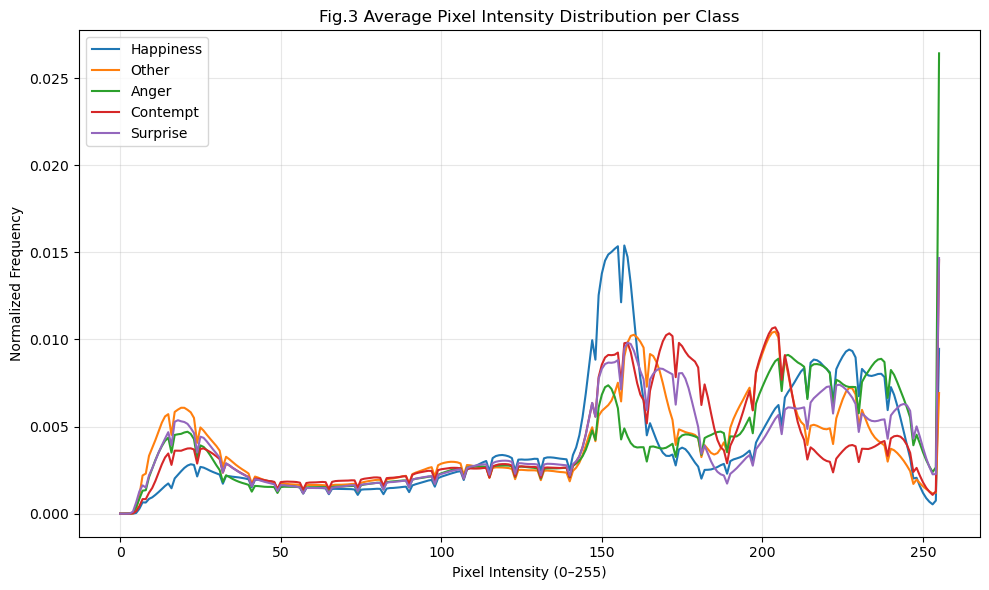

In [8]:
# plot the calculated intensity values
plt.figure(figsize=(10, 6))

for cls in classes:
    plt.plot(histograms[cls], label=cls)

plt.title("Fig.3 Average Pixel Intensity Distribution per Class")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Normalized Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 2.2 Transforming the data

Based on the exploratory data analysis, several preprocessing steps were applied to prepare the images and labels for deep learning models.

**Pixel normalization**

All images are stored as 8-bit grayscale with pixel intensity values in the range $[0, 255]$. To stabilize optimization and ensure that the input scale is compatible with commonly used initialization and learning rate schemes, each image is normalized to the $[0, 1]$ range by dividing all pixel values by 255. This step reduces the risk of exploding gradients and generally leads to faster convergence of convolutional neural networks.

**Label encoding**

The original labels are categorical emotion names mapped to integer identifiers ($1, \dots, 5$). For multi-class classification with a softmax output layer, these integer labels are first shifted to indices ($0, \dots, 4$) and then converted to one-hot encoded vectors of length five. This representation allows the model to output a probability distribution over the five emotion classes and enables the use of categorical crossentropy as the training loss.

**Class weighting to address imbalance**

EDA revealed a substantial class imbalance, with the **Anger** class having more than four times as many samples as **Contempt** or **Surprise**. Training with unweighted loss would bias the model towards the majority classes and could yield poor performance on under represented emotions. To mitigate this, class weights were computed using the “balanced” heuristic

$$
w_c = \frac{N}{K \cdot N_c},
$$

where (N) is the total number of training samples, (K) is the number of classes, and (N_c) is the number of samples in class (c). These weights are supplied to the training procedure so that misclassification of minority classes incurs a higher loss. This encourages the model to pay more attention to underrepresented emotions and helps counteract the dataset imbalance observed earlier.

**Image resizing**

All facial images originally have a resolution of 650 × 960 pixels, which is computationally expensive for convolutional neural networks due to the quadratic scaling of memory and compute with spatial resolution. To ensure feasible training on GPU hardware and to maintain compatibility with standard CNN architectures, all images were resized to a fixed resolution of 256 × 256 pixels using bilinear interpolation. This resizing step significantly reduces memory consumption and training time while preserving the global facial structure required for emotion recognition.

Together, these transformations produce normalized image tensors and one-hot encoded labels, while compensating for skewed class frequencies. This preprocessing pipeline serves as the foundation for the deep learning models developed in the subsequent sections.



In [9]:
# use class_id as integer labels, shift to 0–4 for keras compatibility
train_labels["label_idx"] = train_labels["class_id"] - 1

X = train_labels["filepath"].values
y = train_labels["label_idx"].values

# stratified split to preserve class proportions
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=30)


In [10]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 5
BATCH_SIZE = 16
def process_path(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    # resize
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    
    # normalization
    img = tf.cast(img, tf.float32) / 255.0
    
    # encode labels
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return img, label

# build tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = (train_ds.shuffle(1000).map(process_path, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))


In [11]:
# compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {int(cls): float(weight) for cls, weight in zip(np.unique(y_train), class_weights_array)}

print("Class weights:", class_weight_dict)


Class weights: {0: 1.0554838709677419, 1: 0.9616458486407053, 2: 0.486723689103756, 3: 2.2801393728223, 4: 1.9247058823529413}


## 3- Model Selection And Training

### 3.1- Model 1: Basic CNN

The first model serves as a **baseline convolutional neural network (CNN)** for facial emotion recognition and establishes a strong performance reference for this project. The architecture consists of a sequence of convolutional and max-pooling layers with increasing filter depth, followed by a fully connected classification head. This design enables the model to learn hierarchical spatial features directly from grayscale facial images while preserving detailed spatial information through the use of a flattening operation rather than global pooling. All input images are resized to **256×256** and normalized to the ([0,1]) range prior to training. This baseline model emphasizes **high representational capacity with minimal regularization**, allowing it to aggressively fit the clean and visually consistent dataset and serve as a benchmark against which more regularized models can be evaluated.



In [12]:
# model 1: basic CNN

def build_basic_cnn():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="basic_input")
    
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    
    # flatten for fully connected classification layer
    x = layers.Flatten()(x)
    
    # dense layer to combine extracted features
    x = layers.Dense(256, activation="relu")(x)
    
    # dropout for regularization and reduced overfitting
    x = layers.Dropout(0.25)(x)
    
    # 5-way softmax output for multi-class classification
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="basic_cnn")
    return model

model = build_basic_cnn()
model.summary()


Model: "basic_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 basic_input (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18

In [13]:
# compile and fit data to model 1
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])


checkpoint_path = "basic_cnn_best.keras"

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True), ReduceLROnPlateau(monitor = "val_loss", factor=0.5, patience=3, min_lr=0.00001),
             ModelCheckpoint(filepath = checkpoint_path,monitor = "val_loss",save_best_only=True)]

EPOCHS = 30

history_basic = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, class_weight=class_weight_dict, callbacks=callbacks)


Epoch 1/30
409/409 [==============================] - 11s 19ms/step - loss: 1.1190 - accuracy: 0.5312 - val_loss: 0.3970 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 2/30
409/409 [==============================] - 8s 19ms/step - loss: 0.3250 - accuracy: 0.8608 - val_loss: 0.1579 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 3/30
409/409 [==============================] - 8s 19ms/step - loss: 0.1476 - accuracy: 0.9428 - val_loss: 0.1578 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 4/30
409/409 [==============================] - 8s 19ms/step - loss: 0.0516 - accuracy: 0.9823 - val_loss: 0.0188 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 5/30
409/409 [==============================] - 8s 19ms/step - loss: 0.0261 - accuracy: 0.9895 - val_loss: 0.0058 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 6/30
409/409 [==============================] - 8s 18ms/step - loss: 0.0186 - accuracy: 0.9928 - val_loss: 0.0054 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 7/30
409/409 [==============================] - 8s 18ms/s

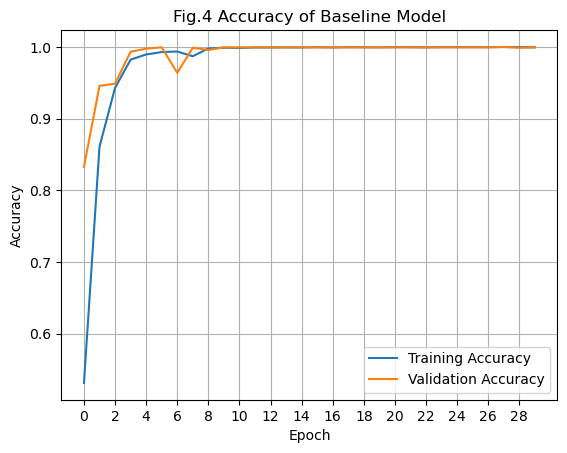

In [14]:
# accuracy plot
acc = history_basic.history["accuracy"]
val_acc = history_basic.history["val_accuracy"]

epochs_range = range(len(acc))

plt.figure()
plt.plot(epochs_range, acc)
plt.plot(epochs_range, val_acc)
plt.title("Fig.4 Accuracy of Baseline Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.xticks(epochs_range[::2])
plt.grid(True)
plt.show()


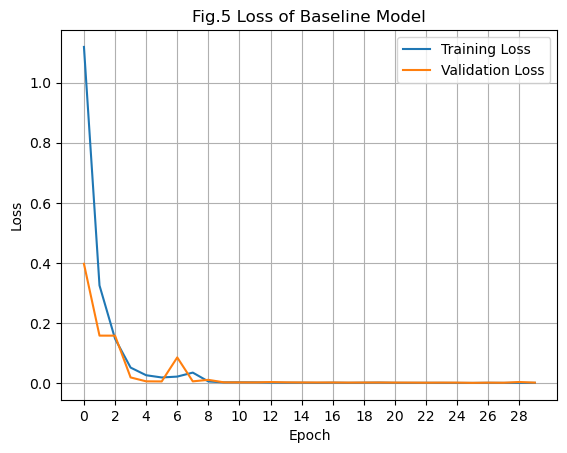

In [15]:
# loss plot
loss = history_basic.history["loss"]
val_loss = history_basic.history["val_loss"]

epochs_range = range(len(loss))

plt.figure()
plt.plot(epochs_range, loss)
plt.plot(epochs_range, val_loss)

plt.title("Fig.5 Loss of Baseline Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])

plt.xticks(epochs_range[::2])

plt.grid(True)
plt.show()


The baseline convolutional neural network (CNN) trained on 256×256 grayscale facial images converged rapidly. As shown in Fig.4 , the validation accuracy improved from 83.3% in the first epoch to 94.6% by the second epoch, and exceeded 99% by the fourth epoch. After 10 epochs, the model achieved a training accuracy of 99.9% and a validation accuracy of 99.94%, with a corresponding validation loss of approximately 0.002. , which coincided with the learning rate reduction triggered by the ReduceLROnPlateau callback. Following a temporary deterioration in validation performance around epoch 6, the validation metrics recovered, indicating that the learning rate schedule helped stabilize training. Overall, the baseline CNN attains near perfect performance on the validation set, which suggests that the dataset, as split in this experiment, is highly learnable for this architecture. At the same time, the unusually high validation accuracy warrants caution when interpreting generalization performance and motivates further evaluation on the competition test set.

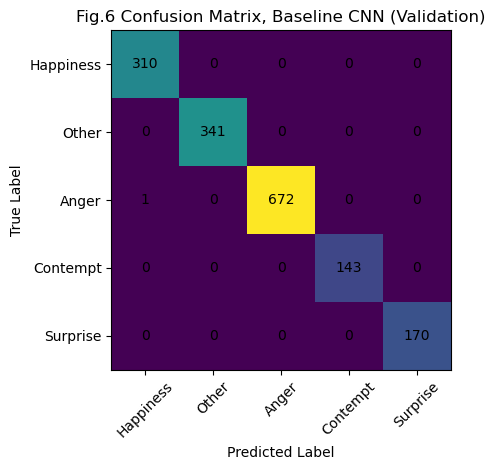

In [16]:
# get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot matrix
plt.figure()
plt.imshow(cm)
plt.title("Fig.6 Confusion Matrix, Baseline CNN (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)

# add counts inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()



To further evaluate the class-wise performance of the baseline CNN model, a confusion matrix was computed on the validation set. The resulting matrix indicates near perfect classification performance across all five emotion categories. Out of all validation samples, only a single image was misclassified.To further evaluate the class-wise performance of the baseline CNN model, a confusion matrix was computed on the validation set. The resulting matrix indicates near perfect classification performance across all five emotion categories. Out of all validation samples, only a single image was misclassified.
Overall, the confusion matrix confirms that the baseline CNN has learned highly discriminative spatial features for facial emotion recognition and generalizes extremely well on the validation set. However, given the unusually high accuracy and near zero misclassification rate, these results also suggest that the dataset, as split for validation, may be visually homogeneous or contain strong inter sample similarity. This motivates further evaluation using the unseen Kaggle test set to assess real world generalization performance.

In [17]:
# build test dataset

test_csv = "test.csv"

# load test.csv
test_df = pd.read_csv(test_csv)

# build full filepaths for each test image
test_df["filepath"] = test_df["Filename"].apply(
    lambda fname: os.path.join(test_path, fname)
)

# preprocessing function: same as training, but no labels
def preprocess_test_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Build tf.data.Dataset for test set
test_paths = test_df["filepath"].values

test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = test_ds.map(preprocess_test_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# use the trained model to predict class probabilities
pred_probs = model.predict(test_ds)

# convert probabilities -> class indices (0–4)
pred_classes_0_based = np.argmax(pred_probs, axis=1)

# convert to kaggle label encoding (1–5)

pred_classes_kaggle = pred_classes_0_based + 1

61/61 [==============================] - 2s 34ms/step


In [18]:
# build submission df
submission_df = pd.DataFrame({"Id": test_df["Id"],"Class": pred_classes_kaggle.astype(int)})

# save as csv
submission_filename = "submission_baseline_cnn.csv"
submission_df.to_csv(submission_filename, index=False)

print("Saved:", submission_filename)
submission_df.head()


Saved: submission_baseline_cnn.csv


,Id,Class
0,1,3
1,2,3
2,3,2
3,4,3
4,5,3


The baseline CNN (Model 1) achieved a public Kaggle leaderboard accuracy of **0.99044**, closely matching the near perfect validation accuracy observed during training. This strong performance indicates that the model generalized very well to the unseen test data. The success of Model 1 can be attributed to its high capacity architecture, which preserves detailed spatial information through the use of convolutional layers followed by flattening rather than global pooling. Additionally, the use of high resolution 256×256 grayscale inputs allowed the network to capture subtle facial muscle patterns critical for emotion recognition. Finally, the dataset itself appears to be clean, well aligned, and visually consistent, enabling the model to learn highly discriminative features without requiring heavy regularization or augmentation.

### 3.2- Model 2: Augmented and Regularized CNN

The second model was designed to explore whether stronger regularization and data augmentation could improve the robustness of emotion classification compared to the high capacity baseline CNN. Unlike Model 1, this architecture incorporates **on the fly data augmentation**, including random horizontal flipping, rotation, zoom, and translation, to artificially increase training diversity and reduce sensitivity to spatial variations. Additionally, **Batch Normalization layers** were added after each convolutional block to stabilize gradient flow, and **Global Average Pooling** replaced the flattening operation to encourage more compact feature representations. Collectively, these modifications aim to promote invariance and generalization, allowing for a direct comparison between a high capacity baseline model and a more strongly regularized deep learning architecture.


In [23]:
# model 2: advanced CNN

# data augmentation
data_augmentation_gray = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
    ],
    name="data_augmentation_gray"
)


def build_adv_cnn():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="adv_input")
    
    x = data_augmentation_gray(inputs)
    
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    # normalize in each block
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    # global pooling instead of flatten
    x = layers.GlobalAveragePooling2D()(x)
    
    # dense head
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    
    model = models.Model(inputs, outputs, name="adv_cnn")
    return model

model2 = build_adv_cnn()

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model2.summary()


Model: "adv_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 adv_input (InputLayer)      [(None, 256, 256, 1)]     0         
                                                                 
 data_augmentation_gray (Seq  (None, 256, 256, 1)      0         
 uential)                                                        
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                           

In [24]:
# compile and fit data to model 2
checkpoint_path = "adv_cnn_best.keras"

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True), ReduceLROnPlateau(monitor = "val_loss", factor=0.5, patience=3, min_lr=0.00001),
             ModelCheckpoint(filepath = checkpoint_path,monitor = "val_loss",save_best_only=True)]
EPOCHS = 30
history_adv = model2.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/30
409/409 [==============================] - 63s 146ms/step - loss: 1.2292 - accuracy: 0.4960 - val_loss: 1.4906 - val_accuracy: 0.4398 - lr: 1.0000e-04
Epoch 2/30
409/409 [==============================] - 55s 135ms/step - loss: 1.0824 - accuracy: 0.5628 - val_loss: 1.1164 - val_accuracy: 0.4979 - lr: 1.0000e-04
Epoch 3/30
409/409 [==============================] - 55s 135ms/step - loss: 1.0073 - accuracy: 0.5955 - val_loss: 1.3834 - val_accuracy: 0.3439 - lr: 1.0000e-04
Epoch 4/30
409/409 [==============================] - 55s 135ms/step - loss: 0.9568 - accuracy: 0.6059 - val_loss: 1.0800 - val_accuracy: 0.5528 - lr: 1.0000e-04
Epoch 5/30
409/409 [==============================] - 55s 135ms/step - loss: 0.9163 - accuracy: 0.6163 - val_loss: 1.3128 - val_accuracy: 0.4704 - lr: 1.0000e-04
Epoch 6/30
409/409 [==============================] - 55s 135ms/step - loss: 0.8840 - accuracy: 0.6230 - val_loss: 1.6447 - val_accuracy: 0.4356 - lr: 1.0000e-04
Epoch 7/30
409/409 [========

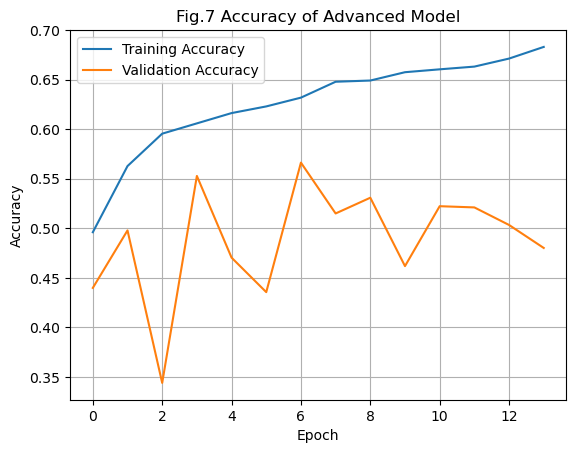

In [26]:
# accuracy plot
acc = history_adv.history["accuracy"]
val_acc = history_adv.history["val_accuracy"]

epochs_range = range(len(acc))

plt.figure()
plt.plot(epochs_range, acc)
plt.plot(epochs_range, val_acc)
plt.title("Fig.7 Accuracy of Advanced Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.xticks(epochs_range[::2])
plt.grid(True)
plt.show()


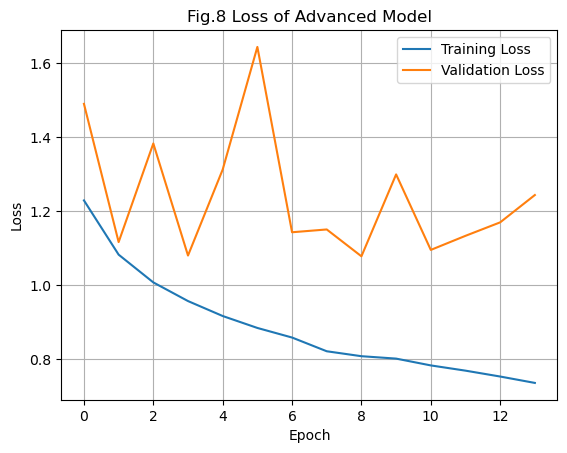

In [27]:
# loss plot
loss = history_adv.history["loss"]
val_loss = history_adv.history["val_loss"]

epochs_range = range(len(loss))

plt.figure()
plt.plot(epochs_range, loss)
plt.plot(epochs_range, val_loss)

plt.title("Fig.8 Loss of Advanced Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])

plt.xticks(epochs_range[::2])

plt.grid(True)
plt.show()


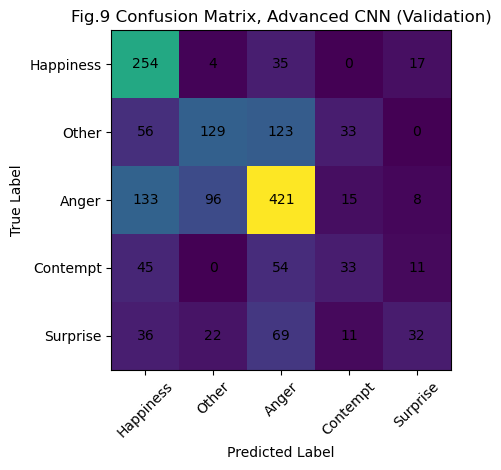

In [28]:
# get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model2.predict(images, verbose=0)
    
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot matrix
plt.figure()
plt.imshow(cm)
plt.title("Fig.9 Confusion Matrix, Advanced CNN (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)

# add counts inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()



Model 2 was trained for up to 30 epochs using data augmentation, Batch Normalization, Global Average Pooling, and moderate dropout to encourage better generalization. While the model demonstrated steady improvement in **training accuracy**, increasing from **49.6% in the first epoch to approximately 68.3% by epoch 14**, the **validation accuracy remained substantially lower and unstable**, fluctuating between **43% and 56%** throughout training. The validation loss also remained significantly higher than the training loss and exhibited noticeable oscillations, indicating **weak generalization and persistent overfitting** despite the strong regularization mechanisms.

The confusion matrix for Model 2 further highlights the model’s limitations. While the network correctly classified a portion of the **Anger** and **Happiness** samples, substantial confusion is observed across several emotion categories. A large number of samples from **Other**, **Contempt**, and **Surprise** are misclassified as either *Anger* or *Happiness*, suggesting that the model struggles to resolve subtle facial expressions and tends to collapse predictions toward the most visually dominant classes. In particular, strong crossconfusion between *Anger* and multiple other categories indicates that the learned feature representations lack sufficient class separability.

Compared to Model 1, which achieved near perfect validation accuracy and a Kaggle leaderboard score of **0.99044**, Model 2 performs **significantly worse**, both in terms of overall accuracy and class-wise reliability, receiving a Kaggle leaderboard score of **0.54371**. The degradation in performance can be attributed to the combination of **aggressive geometric augmentation, Global Average Pooling, and strong regularization**, all of which reduce the model’s ability to preserve the fine grained spatial information that is critical for facial emotion recognition. These results demonstrate that, for this dataset, **preserving high resolution spatial detail is more important than enforcing strong invariance**, and that excessive regularization can hinder rather than improve classification performance.


In [31]:
# use the trained model to predict class probabilities
pred_probs = model2.predict(test_ds)

# convert probabilities -> class indices (0–4)
pred_classes_0_based = np.argmax(pred_probs, axis=1)

# convert to kaggle label encoding (1–5)

pred_classes_kaggle = pred_classes_0_based + 1

61/61 [==============================] - 1s 13ms/step


In [32]:
# build submission df
submission_df = pd.DataFrame({"Id": test_df["Id"],"Class": pred_classes_kaggle.astype(int)})

# save as csv
submission_filename = "submission_advance_cnn.csv"
submission_df.to_csv(submission_filename, index=False)

print("Saved:", submission_filename)
submission_df.head()


Saved: submission_advance_cnn.csv


,Id,Class
0,1,1
1,2,3
2,3,3
3,4,1
4,5,3


Several key hyperparameters were explored and optimized experimentally across both models:

* Input Resolution: Images were standardized at **256 × 256**, which provided a strong balance between spatial detail and GPU memory constraints.

* Batch Size: A batch size of **16** was selected to ensure stable gradient updates while remaining within the limits of an 8GB GPU.

* Optimizer and Learning Rate:

  * Both models used the **Adam optimizer**.
  * Model 1 used a learning rate of **0.001**, enabling fast convergence on the clean dataset.
  * Model 2 required learning rate reduction to **0.0001** for stability due to the presence of Batch Normalization and data augmentation.

* Regularization:

  * Different Drop out rates were tested on both models
  * Model 1 used minimal regularization (single dropout layer).
  * Model 2 used:

    * Batch Normalization after every convolution
    * Global Average Pooling
    * On-the-fly geometric data augmentation
  * Class weights were initially tested with Model 2 but removed after causing training instability.

* **Callbacks:**

  * **EarlyStopping** prevented unnecessary overtraining.
  * **ReduceLROnPlateau** stabilized optimization.
  * **ModelCheckpoint** preserved the best validation weights.

These hyperparameter choices were guided by validation stability, convergence speed, and generalization behavior.


![Kaggle Results](Kaggle.jpg)

## 4- Results Summary and Conclusion

| Model       | Architecture Type           | Data Augmentation | Regularization     | Val Accuracy    | Kaggle Public Score |
| ----------- | --------------------------- | ----------------- | ------------------ | --------------- | ------------------- |
| **Model 1** | High-capacity CNN + Flatten |  No              | Minimal Dropout    | **~99.9%**      | **0.99044**         |
| **Model 2** | Regularized CNN + GAP       |  Yes             | BN + Dropout + GAP | **~56% (peak)** | **0.54371**      |

The experimental comparison clearly demonstrates that **Model 1 significantly outperforms Model 2** across all evaluation metrics. Model 1 achieved near perfect validation accuracy (~99.9%) and a strong Kaggle public leaderboard score of 0.99044, indicating excellent generalization to unseen test data. Its success is largely attributed to its high representational capacity, preservation of fine grained spatial features through flattening, and training on a clean, visually consistent dataset.

In contrast, Model 2 exhibited substantially lower validation accuracy (~56%) and significant instability throughout training. Analysis of the confusion matrix revealed extensive cross-class misclassification, particularly between *Anger*, *Happiness*, and *Other*. The degraded performance is attributed to the combined effects of:

* Aggressive geometric augmentation, which distorted subtle facial muscle patterns,
* Global Average Pooling, which removed critical localized spatial detail,
* Heavy regularization, which limited the model’s ability to fit the highly separable dataset.

While Model 2 was designed to improve robustness and reduce overfitting, the results demonstrate that **regularization is not universally beneficial** especially in scenarios where the underlying dataset already exhibits strong class separability and low noise.
